In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from starkiller import *
import matplotlib.pyplot as plt
%matplotlib notebook

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig_width_pt = 240.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches

Number of sources brighter than 25: 794
wcs shift:  [-1.15498400e+01  4.88020119e+00  1.60871056e-03]
Coords transformed
Calculating PSF coord shift
PSF shift:  [ 0.2064018  -0.55196711  0.        ]


<IPython.core.display.Javascript object>


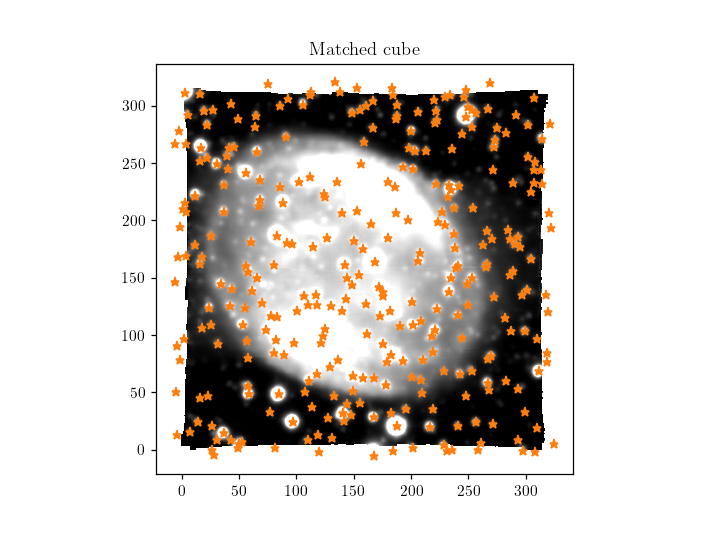

!!! Large difference of 0.8 between model_psf and data_psf!!!
Using the data_psf, override by setting psf_preference='model'
Made PSF
Using the data PSF
Background subtracted
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/Users/rri38/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py", line 463, in _process_worker
    r = call_item()
        ^^^^^^^^^^^
  File "/Users/rri38/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py", line 291, in __call__
    return self.fn(*self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/rri38/miniconda3/lib/python3.12/site-packages/joblib/parallel.py", line 598, in __call__
    return [func(*args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/rri38/miniconda3/lib/python3.12/site-packages/starkiller/helpers.py", line 1020, in _parallel_match
    cors = _calc_cor(spec,model_flux)
          

In [2]:
test = starkiller(file='/Users/rri38/Documents/work/code/muse/test/noao/ADP.2018-08-22T02:56:16.756.fits',numcores=7,savepath='filename',flux_correction=True,
                  spec_catalog='ck+',psf_profile='gaussian',cal_maglim=18,psf_preference='data',show_specs=False,wcs_correction=True,psf_align=True,
                  fuzzy=True)


In [4]:
!open 

In [6]:
from starkiller.helpers import _model_grid, _parallel_match, _refactoring, _has_len



pbs = load_pbs(test.filts,0,'AB',SVO=True)

def _match_obs_to_model(obs_spec,model_files,mags,pbs,num_cores=-1):
    if not _has_len(obs_spec):
        obs_spec = [obs_spec]
    if not _has_len(mags):
        mags = [mags]

    #for i in range(len(obs_spec)):
     #   obs_spec[i] = _smooth_spec(obs_spec[i])

    model_grid = Parallel(n_jobs=num_cores)(delayed(_model_grid)(model_files[i],target_lam=obs_spec[0].wave) for i in range(len(model_files)))
    model_grid = np.array(model_grid).flatten()
    model_flux, model_ebv = zip(*[_refactoring(m) for m in model_grid])
    model_flux = np.array(model_flux); model_ebv = np.array(model_ebv)
    cor, ind = zip(*Parallel(n_jobs=num_cores)(delayed(_parallel_match)(spec, model_flux) for spec in obs_spec))
    cor = np.array(cor); ind = np.array(ind)
    model_spec = model_grid[ind]
    ebv = model_ebv[ind]
    for i in range(len(model_spec)):
        model_spec[i] = my_norm(model_spec[i],pbs,mags[i],name=model_spec[i].name)

    return model_spec, cor, ebv


def match_spec_to_model(specs,mags,pbs,catalog='ck+',num_cores=-1):
    """
    Match an input spectrum to a model spectrum.

    Parameters
    ----------
    spec : pysynphot.spectrum.ArraySpectrum
        Input spectrum
    catalog : str
        Name of the model catalog to compare to. The default is 'ck+'.

    Returns
    -------
    model : pysynphot.spectrum.ArraySpectrum
        Best fitting model spectrum.
    cor : float
        Correlation coefficient of the best fitting model spectrum.
    redshift : float
        Redshift of the input spectrum.
    """
    specs = np.array(specs)
    #lam = spec.wave
    #flux = spec.flux
    #flux = savgol_filter(flux,101,1)
    if 'ck' in catalog.lower():
        path = f'{package_directory}data/ck04_stsci/*'
        #path = f'{package_directory}data/munari05/*'
        model_files = glob(path)
        #model, cor = _compare_catalog(model_files,lam,flux)
        models, cor, ebvs = _match_obs_to_model(specs,model_files,mags,pbs,num_cores=num_cores)

        if '+' in catalog:
            high_t = []
            low_t = []
            low_temps = []
            high_temps = []
            for i in range(len(models)):
                model = models[i]
                temp = int(model.name.split('_')[-2])
                if temp <= 7000:
                    low_t += [i]
                    low_temps += [temp]
                elif temp >= 15000:
                    high_t += [i]
                    high_temps += [temp]
            high_t = np.array(high_t)
            low_t = np.array(low_t)
            high_temps = np.array(high_temps)
            low_temps = np.array(low_temps)

            if len(low_t) > 0:
                path = f'{package_directory}data/marcs-t02/*'
                model_files = np.array(glob(path))
                temps = np.array([int(x.split('/')[-1][1:5]) for x in model_files])
                ul = np.max(low_temps) + 500; ll = np.min(low_temps) - 500
                if np.min(low_temps) <= 3600:
                    ll = 2500
                ind = (temps >= ll) & (temps <= ul)
                model_files = model_files[ind]
                model2, cor2, ebv = _match_obs_to_model(specs[low_t],model_files,mags[low_t],pbs,num_cores=num_cores)
                ind = cor2 > cor[low_t]
                #models[low_t][ind] = model2[ind]
                #cor[low_t][ind] = cor2[ind]
                #ebvs[low_t][ind] = ebv[ind]
                models[low_t] = model2
                cor[low_t] = cor2
                ebvs[low_t] = ebv

            if len(high_t) > 0:
                path = f'{package_directory}data/griddl-ob-i-line/*'
                model_files = np.array(glob(path))
                model2, cor2, ebv = _match_obs_to_model(specs[high_t],model_files,mags[high_t],pbs,num_cores=num_cores)
                ind = cor2 > cor[high_t]
                #models[high_t][ind] = model2[ind]
                #cor[high_t][ind] = cor2[ind]
                #ebvs[high_t][ind] = ebv[ind]
                models[high_t] = model2
                cor[high_t] = cor2
                ebvs[high_t] = ebv

    elif catalog.lower() == 'eso':
        path = f'{package_directory}data/eso_spec/*'
        model_files = glob(path)
        models, cor, ebvs = _match_obs_to_model(specs,model_files,mags,pbs,num_cores=num_cores)#_compare_catalog(path,lam,flux)
    else:
        m = '!! No valid model spectral catalog selected !!'
        raise ValueError(m)
    redshift = []
    for spec in specs:
        shift,zerr, _ = calc_redshift(spec)
        redshift += [shift]

    #redshift = 0
    #model = model.redshift(-redshift)

    return models, cor, redshift, ebvs


In [7]:
model,cors,redshift,ebvs = match_spec_to_model(test.specs,test.mags,pbs,test.spec_cat)



KeyboardInterrupt: 

In [26]:
models = model

In [37]:
a = []
for i in range(10):
    a += [i]

In [38]:
a

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [42]:
i

189

In [45]:
np.array(low_t)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  11,  12,  13,
        14,  15,  16,  19,  20,  21,  23,  24,  25,  26,  28,  29,  31,
        37,  40,  44,  46,  47,  48,  50,  53,  54,  55,  58,  59,  61,
        62,  63,  68,  71,  72,  73,  76,  83,  88,  97,  98,  99, 101,
       104, 108, 109, 112, 114, 118, 120, 125, 126, 128, 130, 131, 132,
       135, 137, 140, 144, 146, 149, 153, 165, 168, 177, 178, 179, 184,
       186])

In [55]:
specs = np.array(test.specs)
mags = test.mags

In [62]:
high_t = []
low_t = []
low_temps = []
high_temps = []
for i in range(len(models)):
    model = models[i]
    temp = int(model.name.split('_')[-2])
    if temp <= 7000:
        low_t += [i]
        low_temps += [temp]
    elif temp >= 15000:
        high_t += [i]
        high_temps += [temp]
high_t = np.array(high_t)
low_t = np.array(low_t)
high_temps = np.array(high_temps)
low_temps = np.array(low_temps)


In [64]:
temps = np.array([int(x.split('/')[-1][1:5]) for x in model_files])

In [223]:
specs[low_t][j]

In [225]:
a = calc_redshift(specs[low_t][j])

Hb
None
NaD
[[ 8.16564838e-05 -6.30669119e-05 -4.15651666e-05  2.21984557e-04
  -7.25168362e-05  5.64531743e-05  2.14828361e-04]
 [-6.30669119e-05  1.76166832e-03 -1.28076812e-03  2.73201131e-03
   1.20069383e-05  1.89539505e-04 -4.80829005e-04]
 [-4.15651666e-05 -1.28076812e-03  1.42323325e-02 -2.63053244e-03
  -4.98219348e-04  1.85705729e-03 -3.32409281e-03]
 [ 2.21984557e-04  2.73201131e-03 -2.63053244e-03  1.42113917e-02
  -7.98916261e-04  2.50865432e-03 -3.18118346e-03]
 [-7.25168362e-05  1.20069383e-05 -4.98219348e-04 -7.98916261e-04
   1.99943206e-03 -2.05621876e-03  3.61620826e-03]
 [ 5.64531743e-05  1.89539505e-04  1.85705729e-03  2.50865432e-03
  -2.05621876e-03  1.89007551e-02 -5.79848471e-03]
 [ 2.14828361e-04 -4.80829005e-04 -3.32409281e-03 -3.18118346e-03
   3.61620826e-03 -5.79848471e-03  1.96461586e-02]]
Ha
[[ 0.03198888 -0.03240122 -0.01049213 -0.02392766]
 [-0.03240122  1.35117391  0.5726732  -0.44436179]
 [-0.01049213  0.5726732   1.19189645 -0.23079773]
 [-0.0239276

In [227]:
a[0]

-0.00023764853443570072

In [226]:
a

(-0.00023764853443570072,
 8.948757020350592e-06,
 {'Hb': {'fit': <CompoundModel(amplitude_0=0.94481679, amplitude_1=0.09861894, mean_1=4853.11397643, stddev_1=0.)>,
   'wave': array([4842.33447266, 4843.58447266, 4844.83447266, 4846.08447266,
          4847.33447266, 4848.58447266, 4849.83447266, 4851.08447266,
          4852.33447266, 4853.58447266, 4854.83447266, 4856.08447266,
          4857.33447266, 4858.58447266, 4859.83447266, 4861.08447266,
          4862.33447266, 4863.58447266, 4864.83447266, 4866.08447266,
          4867.33447266, 4868.58447266, 4869.83447266, 4871.08447266,
          4872.33447266, 4873.58447266, 4874.83447266, 4876.08447266,
          4877.33447266, 4878.58447266, 4879.83447266, 4881.08447266]),
   'flux': array([0.98480042, 1.01313858, 1.03385832, 0.98373414, 0.97029293,
          1.02115413, 1.01737934, 1.02868429, 0.98558199, 0.93926831,
          0.83416205, 0.89231346, 0.84254633, 0.67678828, 0.93142947,
          1.04047595, 0.87750463, 0.81426164, 

In [224]:
def calc_redshift(spec):
    """
    Calculate the redshift of an input spectrum by fitting Gaussians to notable absorption lines.

    Lines used:
        Hb
        NaD
        Ha
        CaII triplet (a b c)

    Parameters
    ----------
    spec : pysynphot.spectrum.ArraySpectrum
        Input spectrum

    Returns
    -------
    shift : float
        Redshift of the spectrum.
    fitted : dict
        Dictionary containing the fit results for each absorption line.
    """
    from astropy.modeling import models,fitting
    from astropy import modeling
    lines = {'Hb':np.array([4861.323]),
         'NaD':np.array([5889.951, 5895.924]),
         'Ha':np.array([6562.797]),
         'CaII_a':np.array([8498.020]),
         'CaII_b':np.array([8542.088]),
         'CaII_c':np.array([8662.138])
            }
    fitted = {}
    for line in lines.keys():
        print(line)
        fits = []
        wave = []
        flux = []
        em = lines[line]
        cont = []
        dip = []
        for i in range(len(em)):
            cont += [np.nanmedian(spec.sample(np.arange(em[i]+20,em[i]+40)))]
            dip += [spec.sample(em[i])/cont[i] - 1]

        mod = []
        if line == 'NaD':
            g_init = (models.Const1D(1) + models.Gaussian1D(amplitude=(dip[0]), mean=em[0], stddev=1)
                      + models.Gaussian1D(amplitude=(dip[1]), mean=em[1], stddev=1))
            mod = g_init
            ind = (spec.wave > em[0]-20) & (spec.wave < em[1]+20)
            wave = spec.wave[ind]
            flux = spec.flux[ind]/cont[0]
        else:
            for i in range(len(em)):
                g_init = (models.Const1D(1) + models.Gaussian1D(amplitude=(dip[i]), mean=em[i], stddev=1))
                mod = g_init
                ind = (spec.wave > em[0]-20) & (spec.wave < em[0]+20)
                wave = spec.wave[ind]
                flux =  spec.flux[ind]/cont[i]


        fit_mod = fitting.LevMarLSQFitter(calc_uncertainties=True)

        finite = np.isfinite(flux)
        if np.nansum(finite) > 10:
            g = fit_mod(mod, wave[finite], flux[finite])
            covariance = fit_mod.fit_info['param_cov']
            print(covariance)
            if line == 'NaD':
                diff = np.mean(np.array([g.mean_1.value/em[0]-1,g.mean_2.value/em[1]-1]))
                if covariance is not None:
                    error = np.sqrt(np.diag(fit_mod.fit_info['param_cov']))
                    pos_er = abs(np.nanmean(np.array([error[2] / (g.mean_1.value-em[0]),error[5] / (g.mean_2.value-em[1])])))
                    amp_er = abs(np.nanmean(error[[1,4]]) / np.nanmean([g.amplitude_1.value,g.amplitude_2.value]))
                else:
                    pos_er = 10; amp_er = 10

            else:
                diff = g.mean_1 / em[0] - 1
                if covariance is not None:
                    error = np.sqrt(np.diag(fit_mod.fit_info['param_cov']))
                    pos_er = abs(error[2] / (g.mean_1.value-em[0]))
                    amp_er = abs(error[1] / g.amplitude_1.value)
                else:
                    pos_er = 10; amp_er = 10
            m = g(wave)
            cor = pearsonr(m[finite],flux[finite]).correlation

            if (g.amplitude_1.value < 0) & (amp_er < 0.1) & (pos_er < 0.2):
                good = True
            else:
                good = False
        else:
            g = None
            cor = 0
            diff = np.nan
        fitted[line] = {'fit':g,'wave':wave,'flux':flux,'shift':diff,'cor':cor,'quality':good,'error':abs(pos_er*diff)}

    shift = []
    er = []
    for line in lines.keys():   
        if fitted[line]['quality']:
            shift += [fitted[line]['shift']]
            er += [fitted[line]['error']]
    er = np.array(er)
    shift = np.nansum(shift/er**2)/np.nansum(1/er**2) #np.average(shift,weights=abs(1/er))
    er = np.sqrt(1/np.nansum(1/er**2))
    if np.isnan(shift):
        shift = 0
        er = 0
    
    return shift, er, fitted

In [70]:
if len(low_t) > 0:
    path = f'{package_directory}data/marcs-t02/*'
    model_files = np.array(glob(path))
    ul = np.max(low_temps) + 500; ll = np.min(low_temps) - 500
    if np.min(low_temps) <= 3600:
        ll = 2500
    ind = (temps >= ll) & (temps <= ul)
    model_files = model_files[ind]
    model2, cor2, ebv = _match_obs_to_model(specs[low_t],model_files,mags[low_t],pbs)
    ind = cor2 > cors[low_t]
    if np.sum(ind) > 0:
        print('replacing')
    #models[low_t][ind] = model2
    #cor[low_t][ind] = cor2
    #ebvs[low_t][ind] = ebv

replacing


In [81]:
ebvs[low_t] - ebv

array([ 0.06,  0.06,  0.21,  0.28,  0.01,  0.3 ,  0.  ,  0.16,  0.06,
        0.07,  0.05, -0.01, -0.02,  0.07,  0.08,  0.21,  0.05,  0.  ,
        0.11,  0.1 ,  0.1 ,  0.32, -0.04,  0.  ,  0.32, -0.01,  0.14,
        0.11,  0.12,  0.04,  0.14,  0.04, -0.07,  0.12,  0.03,  0.  ,
        0.08,  0.37, -0.11,  0.04,  0.08,  0.13,  0.28,  0.09,  0.08,
        0.04,  0.04,  0.36,  0.05,  0.06,  0.06,  0.17,  0.03,  0.27,
        0.29,  0.3 ,  0.19,  0.13,  0.  ,  0.04, -0.01,  0.21,  0.05,
        0.13,  0.01,  0.09, -0.08,  0.09, -0.04,  0.05,  0.49,  0.04,
       -0.07, -0.09, -0.03,  0.  ,  0.09,  0.52,  0.  ])

In [83]:
ebv

array([0.2 , 0.59, 0.92, 0.38, 0.55, 0.28, 0.54, 0.32, 0.48, 0.24, 0.3 ,
       0.42, 0.31, 0.4 , 0.3 , 0.15, 0.43, 0.61, 0.22, 0.49, 0.59, 0.13,
       0.64, 0.  , 0.16, 0.31, 0.01, 0.25, 0.  , 0.18, 0.  , 0.37, 0.39,
       0.  , 0.19, 0.3 , 0.57, 0.07, 0.24, 0.6 , 0.28, 0.  , 0.03, 0.35,
       0.64, 0.54, 0.33, 0.03, 0.56, 0.39, 0.47, 0.  , 0.  , 0.16, 0.01,
       0.05, 0.5 , 0.01, 0.  , 0.57, 0.45, 0.44, 0.36, 0.17, 0.66, 0.15,
       0.26, 0.08, 0.62, 0.24, 0.18, 0.  , 0.47, 0.23, 0.33, 0.  , 0.58,
       1.23, 0.46])

array([ 0.01810791, -0.00417008, -0.00589233, -0.00792858, -0.00242038,
       -0.00742168, -0.01801042, -0.01250629, -0.00310291, -0.01664697,
       -0.00526029,  0.00065885, -0.00767346, -0.00220457, -0.01760754,
        0.00450979, -0.01905469, -0.0098749 ,  0.00464769, -0.01389377,
       -0.01528914,  0.00154679, -0.00903423,  0.01367143, -0.01329713,
       -0.0300625 , -0.00246757, -0.00661691, -0.00428681, -0.00196278,
       -0.00323937, -0.01142255, -0.01134242, -0.0002513 , -0.00206686,
       -0.04689131, -0.00944774, -0.00649749, -0.00588955, -0.0184375 ,
       -0.02108006,  0.00154403, -0.01001402,  0.00273493, -0.01797139,
       -0.01608975,  0.00471583, -0.00520318, -0.02830329, -0.00470193,
       -0.0187668 , -0.00196984, -0.00223788, -0.00845947, -0.01705549,
       -0.01346909, -0.0072451 , -0.00200153, -0.0015655 , -0.0170376 ,
        0.00471945, -0.00662564, -0.01198589, -0.00804563,  0.00079207,
       -0.01404394, -0.00643454, -0.01141854, -0.00792872,  0.00

In [61]:
ind = cor2 > cors[low_t]
if np.sum(ind) > 0:
    print('replacing')


ValueError: operands could not be broadcast together with shapes (103,) (79,) 

In [98]:
np.argmax(cor2)

3

In [100]:
from starkiller.helpers import fit_extinction

In [121]:
np.log(1-.99999999)

-18.420680738927608

In [148]:
def ebv_minimiser(ebv,model,spec,Rv=3.1):
    """
    Minimising function for fitting extinction to a spectrum.

    Parameters
    ----------
    ebv : float
        E(B-V) value to fit.
    model : pysynphot.spectrum.ArraySpectrum
        Model spectrum to apply the extinction to.
    spec : pysynphot.spectrum.ArraySpectrum
        Input spectrum to fit the extinction to.
    Rv : float
        Rv value to use in the extinction fit. The default is 3.1.

    Returns
    -------
    res : float
        Negative correlation coefficient of the model spectrum and the input spectrum.
    """
    print(ebv)
    ext = S.ArraySpectrum(model.wave, 
                    apply(fitzpatrick99(model.wave.astype('double'),ebv*Rv,Rv),model.flux))
    interp = ext.sample(spec.wave)
    corr = pearsonr(spec.flux,interp)[0]
    res = np.log(1-corr)
    return res

def fit_extinction(model,spec,Rv = 3.1):
    """
    Find the best extinction value to maximuze the correlation coefficient between the input spectrum and the model spectrum.

    Parameters
    ----------
    model : pysynphot.spectrum.ArraySpectrum
        Model spectrum to apply the extinction to.
    spec : pysynphot.spectrum.ArraySpectrum
        Input spectrum to fit the extinction to.
    Rv : float
        Rv value to use in the extinction fit. The default is 3.1.

    Returns
    -------
    ext : pysynphot.spectrum.ArraySpectrum
        Model spectrum with the extinction applied.
    ebv : float
        E(B-V) value that maximizes the correlation coefficient between the input spectrum and the model spectrum.
    """
    lam = spec.wave
    ebv0 = 0
    bounds = [[0,10]]

    res = minimize(ebv_minimiser, ebv0,args=(model,spec,Rv),method='Powell',bounds=bounds)
    ebv = res.x[0]
    print(res)
    ext = S.ArraySpectrum(model.wave, 
                    apply(fitzpatrick99(model.wave.astype('double'),ebv*Rv,Rv),model.flux),name=model.name + ' ebv=' + str(np.round(ebv,3)))
    return ext,ebv

In [142]:
ebv0


NameError: name 'ebv0' is not defined

In [153]:
a = fit_extinction(model2[j],specs[low_t][j])

[0.]
[3.81966011]
[6.18033989]
[2.36067977]
[1.45898034]
[0.90169944]
[0.5572809]
[0.34441854]
[0.21286236]
[0.13155617]
[0.08130619]
[0.05024999]
[0.0310562]
[0.01919379]
[0.01186241]
[0.00377436]
[0.00405826]
[0.00410763]
[0.00414097]
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -3.5692075493217885
       x: [ 4.108e-03]
     nit: 1
   direc: [[ 1.000e+00]]
    nfev: 19


In [106]:
a

(<pysynphot.spectrum.ArraySourceSpectrum at 0x4cae08cb0>, 0.0)

In [157]:
model = models[low_t][j]
ebv = 1
Rv = 3.1
ext = S.ArraySpectrum(model.wave, 
                    apply(fitzpatrick99(model.wave.astype('double'),ebv*Rv,Rv),model.flux),name=model.name + ' ebv=' + str(np.round(ebv,3)))

0.5457317522367197


<IPython.core.display.Javascript object>


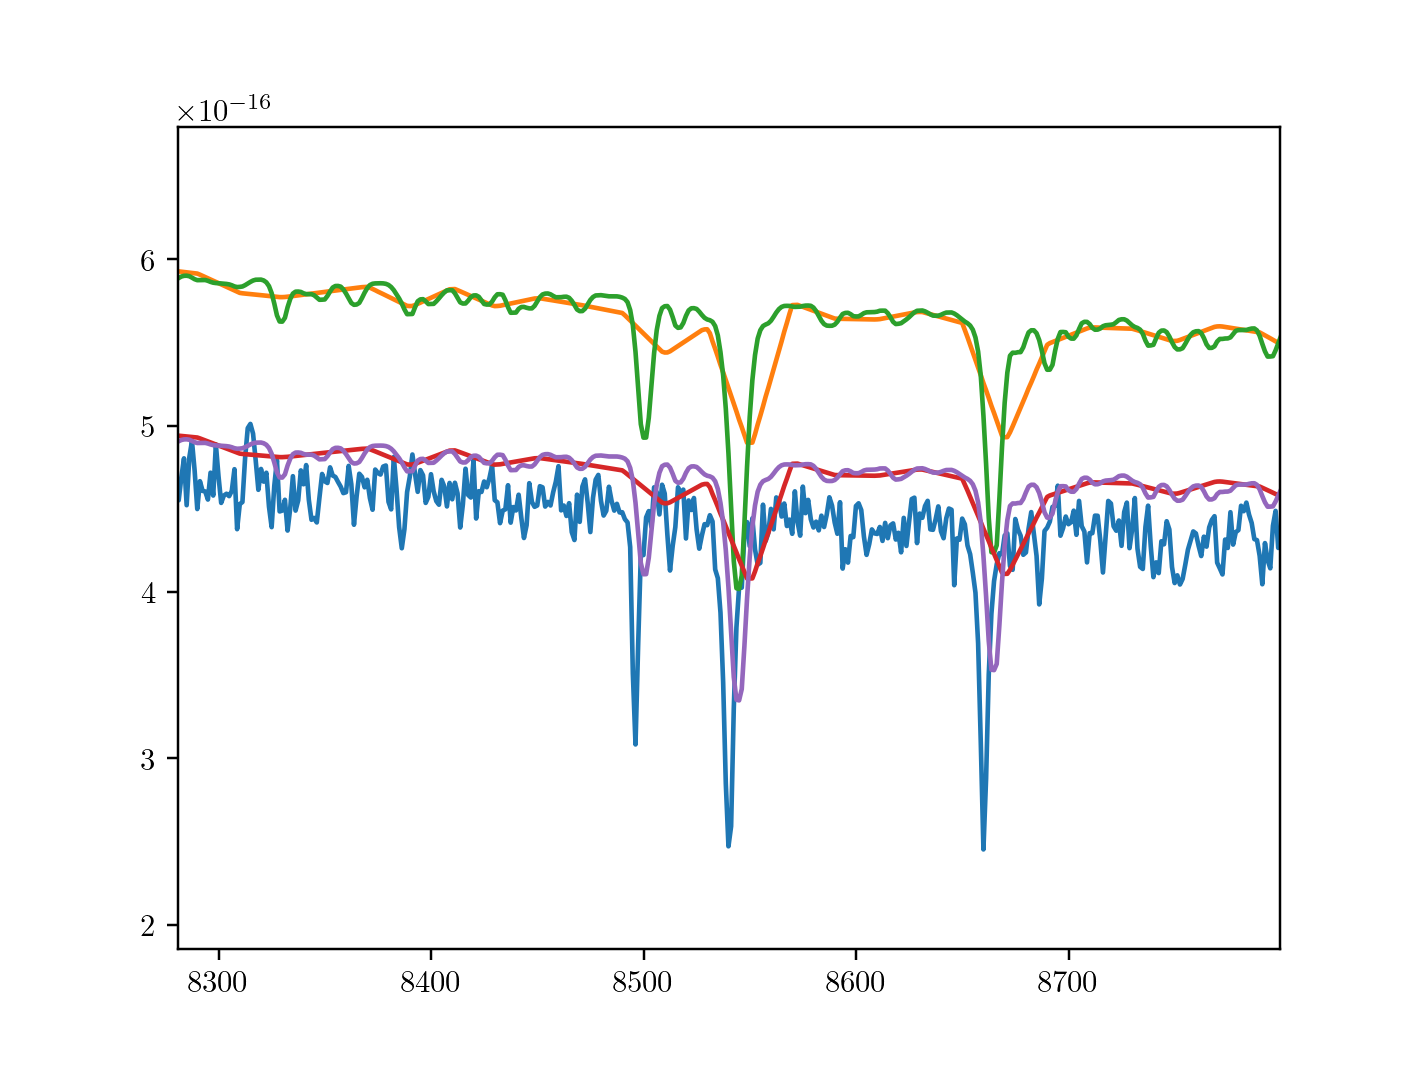

In [175]:
j = 10
print((cor2)[j])
plt.figure()
plt.plot(specs[low_t][j].wave,specs[low_t][j].flux)
plt.plot(models[low_t][j].wave,models[low_t][j].flux)
plt.plot(model2[j].wave,model2[j].flux)
plt.plot(models[low_t][j].wave,models[low_t][j].flux/1.2)
plt.plot(model2[j].wave,model2[j].flux/1.2)

<IPython.core.display.Javascript object>


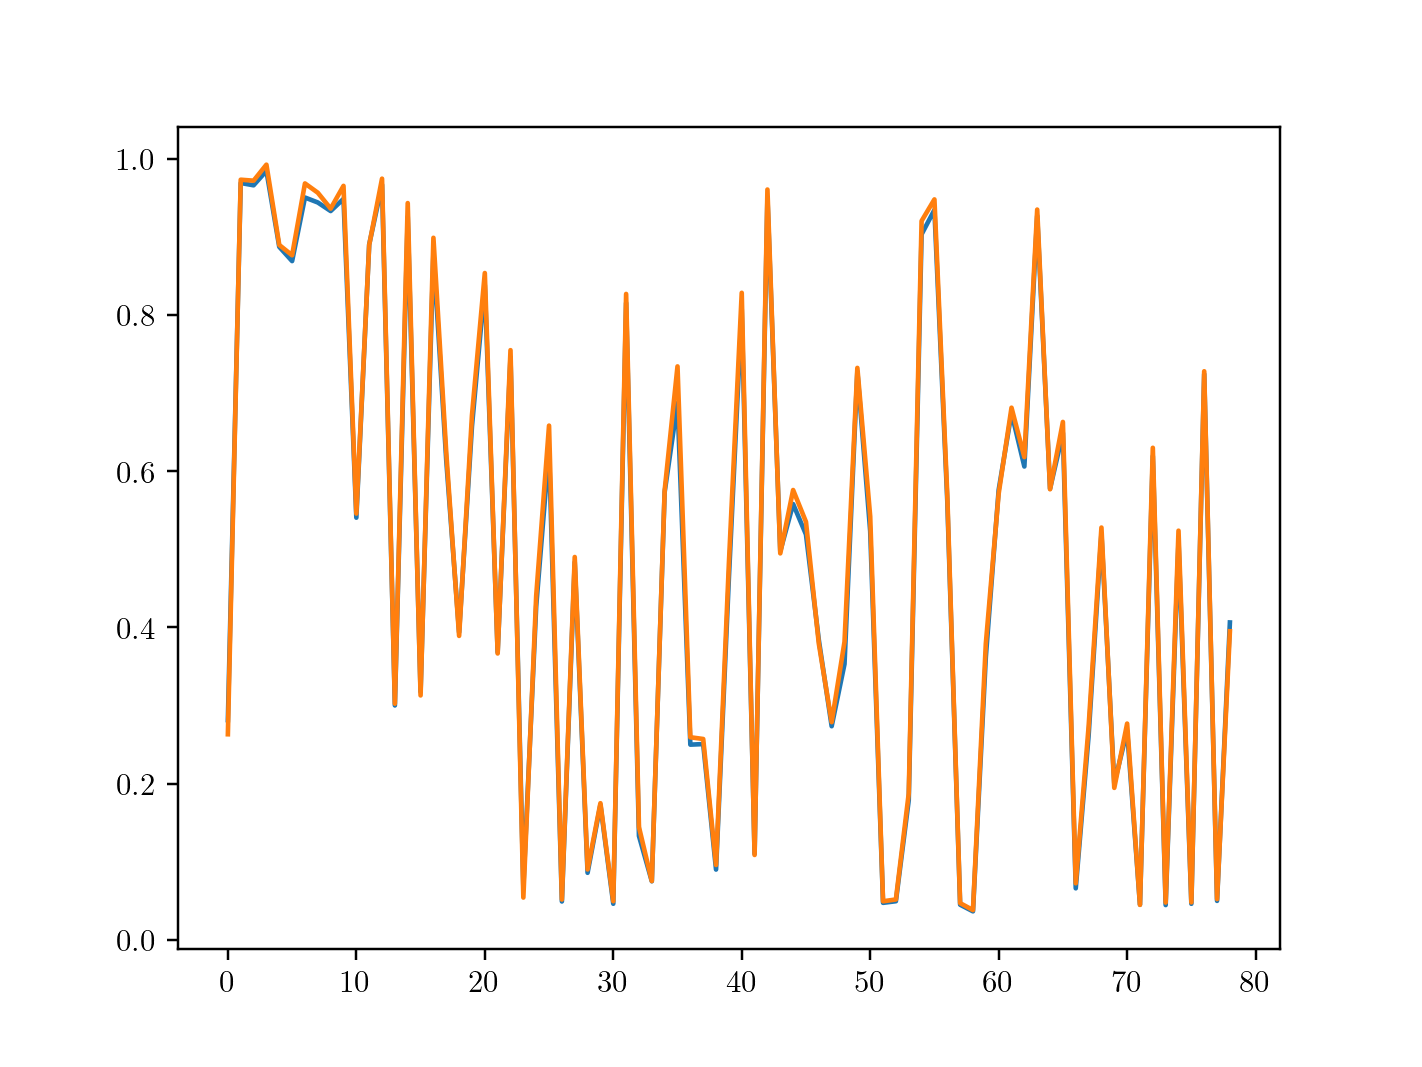

In [71]:
plt.figure()
plt.plot(cors[low_t])
plt.plot(cor2)

In [6]:
a = []
for i in range(3):
    a += [i]
a = np.array(a)

In [7]:
test.specs[a]

TypeError: only integer scalar arrays can be converted to a scalar index

In [9]:
np.array(test.specs)[a]

array([<pysynphot.spectrum.ArraySourceSpectrum object at 0x309ffd100>,
      dtype=object)

In [7]:
test.models[10].name

'ckp00_5750_g45 ebv=0.59'

In [36]:
len(test.specs)

190

<IPython.core.display.Javascript object>


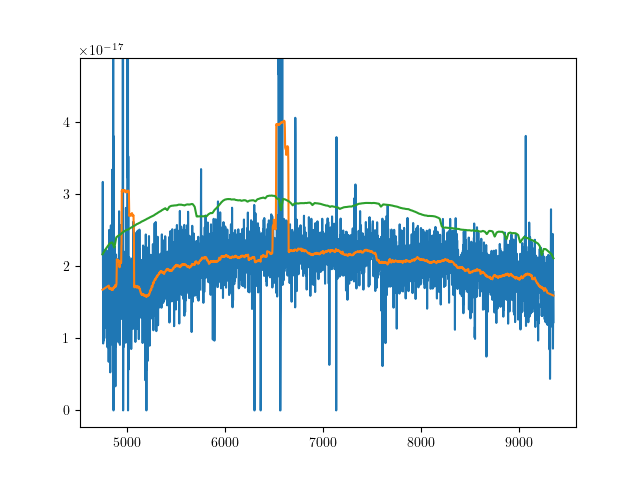

(-2.3285488276669904e-18, 4.889952538100679e-17)

In [5]:
j = 100

m = sigma_clip(test.specs[j].flux,sigma=10).mask
masked = test.specs[j].flux[~m]
ymarg = (np.max(masked)-np.min(masked)) * 0.05


flux = savgol_filter(test.specs[j].flux,101,1)
plt.figure()
plt.plot(test.specs[j].wave,test.specs[j].flux)

plt.plot(test.specs[j].wave,flux)
plt.plot(test.models[j].wave,test.models[j].flux/test.flux_corr)

plt.ylim(np.min(masked)-ymarg,np.max(masked)+ymarg)

In [69]:
test2 = starkiller(file='/Users/rri38/Documents/work/code/muse/test/noao/ADP.2018-08-22T02:56:16.756.fits',numcores=8,savepath='filename',flux_correction=True,
                  spec_catalog='ck',psf_profile='gaussian',cal_maglim=18,psf_preference='data',show_specs=False,wcs_correction=True,psf_align=True,
                  fuzzy=True,run=False)


In [127]:
test2._load_cube()
test2.cat = None
test2._get_cat()

Number of sources brighter than 25: 794


In [128]:
test2._find_fuzzy_mask()

<IPython.core.display.Javascript object>


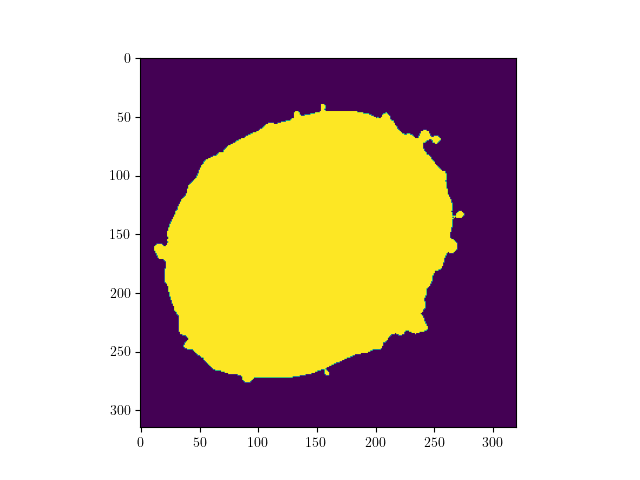

In [129]:
plt.figure()
plt.imshow(test2.fuzzy_mask)

In [179]:
test2._find_sources_cluster()
#test2._dao_s['xcentroid'] = f['xcentroid'].value.astype(int);test2._dao_s['ycentroid'] = f['ycentroid'].value.astype(int)
ind = test2.fuzzy_mask[test2._dao_s['ycentroid'],test2._dao_s['xcentroid']] == 0
test2._dao_s['xcentroid'] = test2._dao_s['xcentroid'][ind];test2._dao_s['ycentroid'] = test2._dao_s['ycentroid'][ind]

test2._fit_DAO_to_cat()


WCS shift:  [ 0.29491566 -1.23826151  0.0882357 ]
wcs shift:  [-8.11359995e+01  1.76151688e+01  3.84776917e-04]


In [224]:
labeled, nr_objects = label(test2.bright_mask > 0) 
obj_size = []
for i in range(nr_objects):
    obj_size += [np.sum(labeled==i)]
obj_size = np.array(obj_size)
targs = np.where((obj_size > 100) & (obj_size<1e4))[0]
ims = []
for i in range(len(targs)):
    ims += [(labeled == targs[i])*1.0]
ims = np.array(ims)
ind = ~sigma_clip(np.sum(ims,axis=(1,2)),sigma=2).mask

ix = test2.cube.shape[2] /2
iy = test2.cube.shape[1] /2
cims = deepcopy(ims[ind])
for i in range(len(cims)):
    ty,tx = np.where(cims[i] > 0)
    my = np.nanmedian(ty)
    mx = np.nanmedian(tx)
    sx = ix - mx; sy = iy - my
    cims[i] = shift(cims[i],[sy,sx])
im = (np.nansum(ims,axis=0) > 0) * 1.
im[im==0] = np.nan
im[test2.fuzzy_mask==1] = np.nan
s = (np.nanmedian(cims,axis=0) > 0.5) * 1.
ty,tx = np.where(s > 0)
s = s[min(ty)-3:max(ty)+4,min(tx)-3:max(tx)+4]

cat_ind = test2.cal_maglim > test2.cat[test2.ref_filter].values
x, y, _ = test2.wcs.all_world2pix(test2.cat.ra.values[cat_ind],test2.cat.dec.values[cat_ind],0,0)
# brute force it
X,Y = np.meshgrid(np.arange(-100,100,10),np.arange(-100,100,10))
positions = np.vstack([X.ravel(), Y.ravel(),X.ravel()*0]).T
res = []
for p in positions:
    guess = basic_image(p,x,y,im,s)
    res += [np.nansum(im - guess)]
res = np.array(res)

ind = np.argmin(res)
x0 = positions[ind]

bounds = [[x0[0]-10,x0[0]+10],[x0[1]-10,x0[1]+10],[0,np.pi/2]]
res2 = minimize(minimize_cats,x0,args=(x,y,im,s),method='Nelder-Mead',bounds=bounds)
test2.wcs_shift = res2.x

In [225]:
test2._transform_coords()

Calculating PSF coord shift
PSF shift:  [ 0.2064018  -0.55196711  0.        ]


<IPython.core.display.Javascript object>


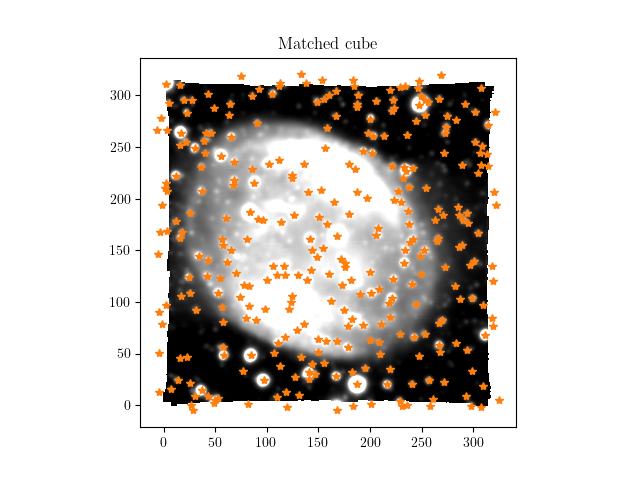

!!! Large difference of 0.8 between model_psf and data_psf!!!
Using the data_psf, override by setting psf_preference='model'


In [227]:
test2.complex_isolation_cals()
test2.make_psf()

<IPython.core.display.Javascript object>


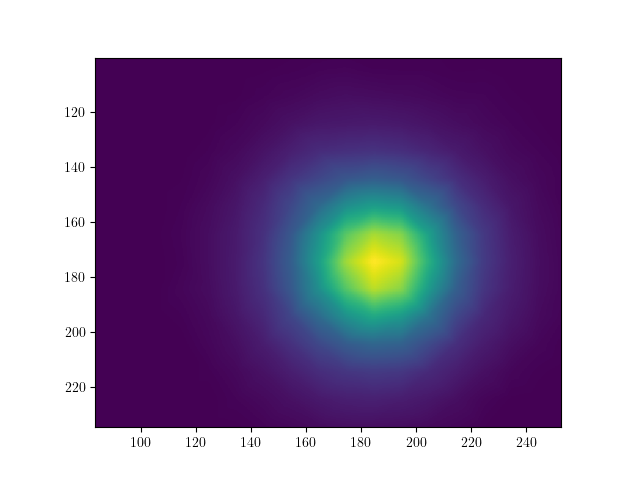

In [228]:
plt.figure()
plt.imshow(test2.psf.data_PSF)

In [ ]:
test2._psf_contained_check()

In [132]:
x, y, _ = test2.wcs.all_world2pix(test2.cat.ra.values,test2.cat.dec.values,0,0)

<IPython.core.display.Javascript object>


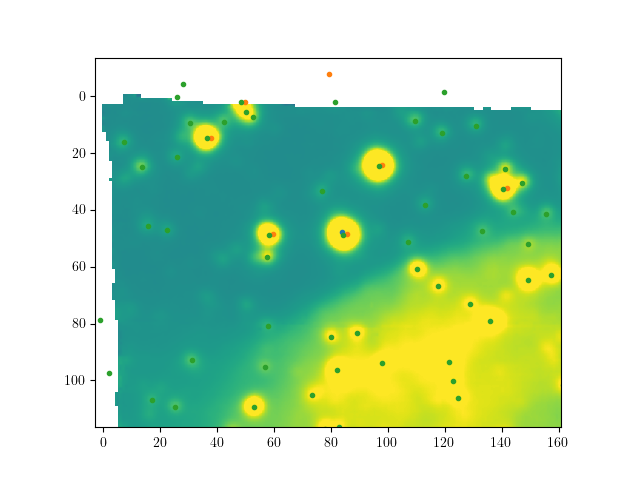

In [226]:
plt.figure()
plt.imshow(test2.image,vmax=200)
plt.plot(test2._dao_s['xcentroid'],test2._dao_s['ycentroid'],'.')
plt.plot(x-10,y+4.54568179,'.')
plt.plot(test2.cat.x.values,test2.cat.y.values,'.')

In [144]:
from photutils.detection import DAOStarFinder
finder = DAOStarFinder(10,3)

In [146]:
f = finder.find_stars(test2.image)

In [150]:
test2.trail

20.808652046684813

In [151]:
test2.angle

45.0

In [153]:
labeled, nr_objects = label(test2.bright_mask > 0) 
obj_size = []
for i in range(nr_objects):
    obj_size += [np.sum(labeled==i)]
obj_size = np.array(obj_size)
image_size = test2.image.shape[0] * test2.image.shape[1]
targs = np.where((obj_size > image_size*1e-3) & (obj_size<image_size*0.1))[0]

<IPython.core.display.Javascript object>


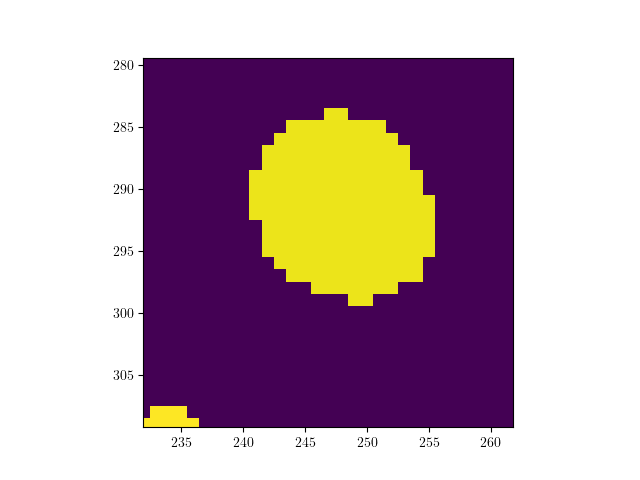

In [155]:
plt.figure()
plt.imshow(labeled)

In [157]:
test2.x_length

18

<IPython.core.display.Javascript object>


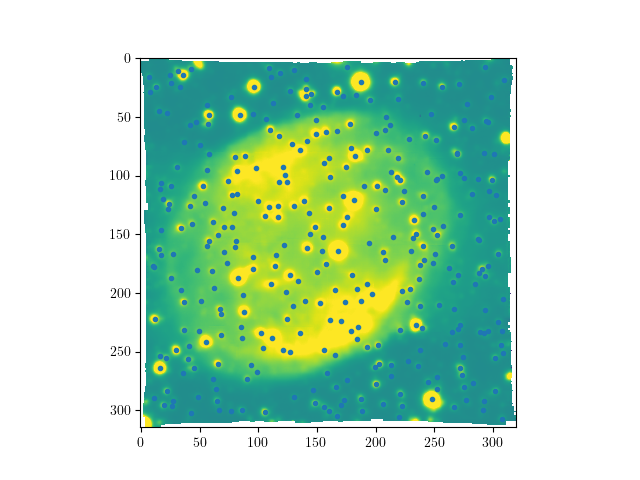

In [149]:
plt.figure()
plt.imshow(test2.image,vmax=200)
plt.plot(f['xcentroid'],f['ycentroid'],'.')

In [39]:
from starkiller import get_gaia_region

In [55]:
cat = get_gaia_region(test.ra,test.dec,1.2*60)

In [56]:
cat

ra        dec                   id  e_RA_ICRS  e_DE_ICRS  \
0     273.003614 -33.885126  4039599020300850816     0.0585     0.0504   
1     273.003019 -33.887361  4039599020328769408     0.1805     0.1539   
2     273.000943 -33.884111  4039599020328769920     0.4956     0.4076   
3     273.003738 -33.887497  4039599024604400640     0.3486     0.2872   
4     273.002737 -33.887379  4039599024604412672     0.4426     0.4125   
...          ...        ...                  ...        ...        ...   
1166  272.996920 -33.854790  4039603560094444800     2.2221     2.1128   
1167  272.999525 -33.856061  4039603560094771328     1.9916     1.2818   
1168  273.000374 -33.856305  4039603560201421568     0.1012     0.0908   
1169  272.999595 -33.855445  4039603560201424896     0.1565     0.1380   
1170  273.001414 -33.853589  4039603560201425664     0.0380     0.0331   

         Plx   e_Plx      PM   pmRA  e_pmRA  ...  URAT1              AllWISE  \
0     0.0961  0.0667   9.084 -3.378   0.074  ...                               
1    -0.2848  0.2061   9.122 -2.582   0.233  ...                               
2     0.7091  0.5915   5.933 -5.554   0.671  ...                               
3     0.5066  0.4007   5.649 -4.399   0.509  ...                               
4    -0.4186  0.4894   2.991 -0.127   0.670  ...                               
...      ...     ...     ...    ...     ...  ...    ...                  ...   
1166     NaN     NaN     NaN    NaN     NaN  ...                               
1167     NaN     NaN     NaN    NaN     NaN  ...                               
1168  0.0917  0.1100  11.348  3.128   0.128  ...                               
1169  0.4270  0.1749   9.181 -6.371   0.197  ...                               
1170  0.1112  0.0433   5.281 -0.982   0.048  ...         J181200.34-335112.9   

      APASS9       GSC23  RAVE5            _2MASS  RAVE6     RAJ2000  \
0       <NA>  S9U9027865         18120088-3353062         273.003633   
1       <NA>                                              273.003033   
2       <NA>                                              273.000972   
3       <NA>                                              273.003761   
4       <NA>                                              273.002738   
...      ...         ...    ...               ...    ...         ...   
1166    <NA>                                              272.996920   
1167    <NA>                                              272.999525   
1168    <NA>                     18120007-3351225         273.000357   
1169    <NA>                     18115990-3351193         272.999630   
1170    <NA>  S9U9030405         18120034-3351127         273.001419   

        DEJ2000        G_filt  
0    -33.885089  GAIA/GAIA3.G  
1    -33.887322  GAIA/GAIA3.G  
2    -33.884102  GAIA/GAIA3.G  
3    -33.887481  GAIA/GAIA3.G  
4    -33.887366  GAIA/GAIA3.G  
...         ...           ...  
1166 -33.854790  GAIA/GAIA3.G  
1167 -33.856061  GAIA/GAIA3.G  
1168 -33.856257  GAIA/GAIA3.G  
1169 -33.855415  GAIA/GAIA3.G  
1170 -33.853566  GAIA/GAIA3.G  

[1171 rows x 58 columns]

In [50]:
origin = np.array(test.wcs.all_pix2world(0,0,0,0))[:2]
corner = np.array(test.wcs.all_pix2world(test.image.shape[1],test.image.shape[0],0,0))[:2]
radius = np.sqrt((origin[0] - corner[0])**2 + (origin[1] - corner[1])**2) / 2 
size = Angle(radius * 1.2, "deg")

In [53]:
size.arcsec

59.72980924304707

In [66]:
x,y,_= test.wcs.all_world2pix(cat.ra.values,cat.dec.values,2000,0)

In [62]:
from astropy.coordinates import SkyCoord
import astropy.units as u

In [63]:
c = SkyCoord('18 12 02.50', '-33 52 07.0',unit=(u.hourangle, u.deg))
cx,cy,_ = test.wcs.all_world2pix(c.ra,c.dec,1000,0)

<IPython.core.display.Javascript object>


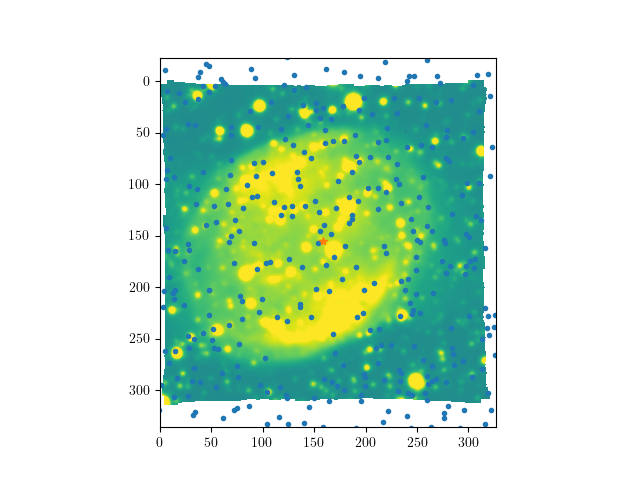

In [67]:
plt.figure()
plt.imshow(test.image,vmax=2e2)
plt.plot(x,y,'.')
plt.plot(cx,cy,'*')

<IPython.core.display.Javascript object>


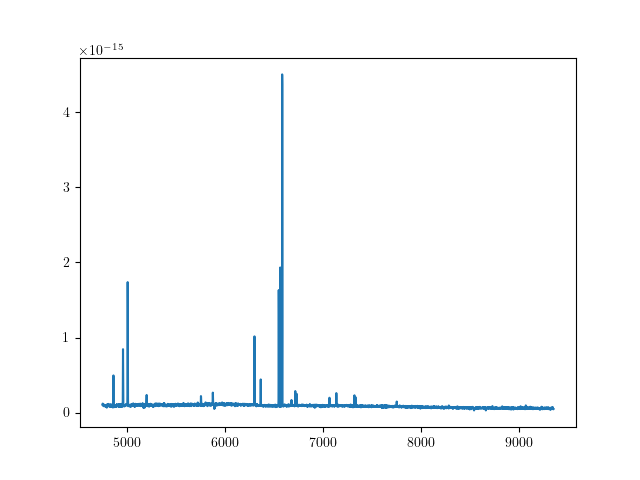

In [6]:
plt.figure()
plt.plot(test.specs[0].wave,test.specs[10].flux)

In [6]:
#redind = int(np.where(test.cat.id.values == 4039600502073223168)[0])
redind = int(np.where(test.cat.id.values == 4039600536432995840)[0])

blueind = int(np.where(test.cat.id.values == 4039600536433072512 )[0])
#blueind = int(np.where(test.cat.id.values == 4039600502077146624)[0])


redpos = (test.cat.x.values[redind],test.cat.y.values[redind])
bluepos = (test.cat.x.values[blueind],test.cat.y.values[blueind])

red_spec = test.specs[redind]
blue_spec = test.specs[blueind]
red_model = test.models[redind]
blue_model = test.models[blueind]

In [11]:
ind = 1800
image = test.cube[ind]#np.nanmedian(test.cube,axis=0)
scene = test.scene.sim[ind]#np.nanmedian(test.scene.sim,axis=0)
diff = np.nanmedian(test.diff,axis=0)



x = test.cat.xint + test.cat.x_offset
y = test.cat.yint + test.cat.y_offset

<IPython.core.display.Javascript object>


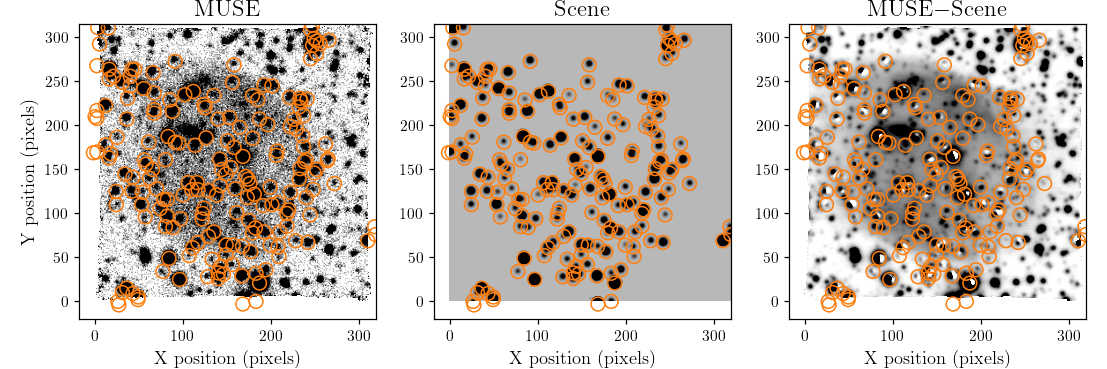

In [12]:
vmin = np.nanpercentile(image,16)
vmax = np.nanpercentile(image,84)

plt.figure(figsize=(1.5*fig_width*2,1*fig_width))
plt.subplot(131)
plt.title('MUSE',fontsize=15)
plt.imshow(image,origin='lower',vmin=vmin,vmax=vmax,cmap='gray_r')
plt.scatter(x, y, s=80, facecolors='none', edgecolors='C1')


#plt.scatter(bluepos[0],bluepos[1], s=80, facecolors='none', edgecolors='C2')
#plt.scatter(redpos[0],redpos[1], s=80, facecolors='none', edgecolors='C0')


plt.xlabel('X position (pixels)',fontsize=12)
plt.ylabel('Y position (pixels)',fontsize=12)

plt.subplot(132)
plt.title('Scene',fontsize=15)
plt.imshow(scene,origin='lower',vmin=vmin,vmax=vmax,cmap='gray_r')
plt.scatter(x, y, s=80, facecolors='none', edgecolors='C1')
plt.xlabel('X position (pixels)',fontsize=12)

plt.subplot(133)
plt.title('MUSE$ - $Scene',fontsize=15)
plt.imshow(diff,origin='lower',vmin=vmin,vmax=vmax,cmap='gray_r')
#plt.plot(x,y,'C1*',ms=5)
plt.scatter(x, y, s=80, facecolors='none', edgecolors='C1')
plt.xlabel('X position (pixels)',fontsize=12)

#plt.scatter(bluepos[0],bluepos[1], s=80, facecolors='none', edgecolors='C2')
#plt.scatter(redpos[0],redpos[1], s=80, facecolors='none', edgecolors='C0')

plt.tight_layout()
#plt.savefig('Nebula_subtraction_exampl_singlewave.pdf',bbox_inches='tight')

<IPython.core.display.Javascript object>


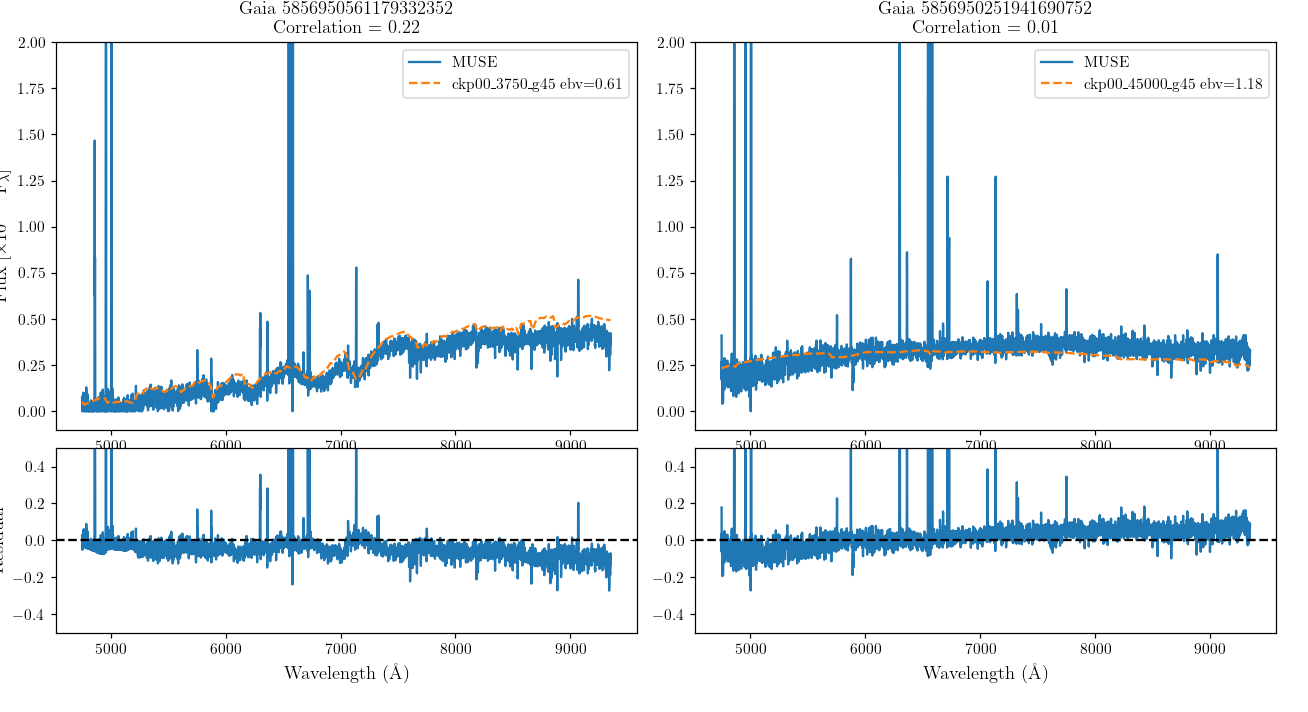

Text(0.5, 8.952351600876051, 'Wavelength ($\\rm \\AA$)')

In [13]:
blue_model = test.models[blueind]

fig, axs = plt.subplot_mosaic('''
                               AB
                               AB
                               CD
                               ''',
                              figsize=(1.5*fig_width*2,1*fig_width))
plt.tight_layout()
plt.subplots_adjust(hspace=0.1)
plt.subplots_adjust(wspace=0.1)

axs['A'].plot(blue_spec.wave,blue_spec.flux*1e16,label='MUSE')
axs['A'].plot(blue_spec.wave,blue_model.sample(blue_spec.wave)/test.flux_corr*test.cat['containment'].values[blueind]*1e16,'--',label = blue_model.name)

axs['A'].set_title(f'Gaia 5856950561179332352 \nCorrelation = {np.round(test.cors[blueind],2)}')
#axs['A'].set_ylabel(r'Flux $\left[\rm \times10^{-16}\; erg/s/cm^2/\AA\right]$',fontsize=12)
axs['A'].set_ylabel(r'Flux $\left[\rm \times10^{-16}\; F_\lambda\right]$',fontsize=12)
axs['A'].set_ylim(-0.1,2)
axs['A'].legend()

axs['C'].plot(blue_spec.wave,-(blue_model.sample(blue_spec.wave)/test.flux_corr*test.cat['containment'].values[blueind]*1e16 - blue_spec.flux*1e16))
axs['C'].axhline(0,color='k',ls='--')
axs['C'].set_ylabel('Residual',fontsize=12)
axs['C'].set_ylim(-0.5,0.5)
axs['C'].set_xlabel(r'Wavelength ($\rm \AA$)',fontsize=12)

axs['B'].plot(red_spec.wave,red_spec.flux*1e16,label='MUSE')
axs['B'].plot(red_spec.wave,red_model.sample(red_spec.wave)/test.flux_corr*1e16,'--',label = red_model.name)
axs['B'].set_title(f'Gaia 5856950251941690752 \nCorrelation = {np.round(test.cors[redind],2)}')
axs['B'].legend(loc=1)
#axs['B'].set_ylim(1.8,6)
axs['B'].set_ylim(-0.1,2)
#axs['A'].set_ylabel(r'Flux $\left[\rm \times10^{-16}\; erg/s/cm^2/\AA\right]$',fontsize=12)
#axs['B'].set_ylabel(r'Flux $\left[\rm \times10^{-16}\; F\lambda\right]$',fontsize=12)


axs['D'].plot(red_spec.wave,-(red_model.sample(red_spec.wave)/test.flux_corr*1e16 - red_spec.flux*1e16))
axs['D'].axhline(0,color='k',ls='--')
axs['D'].set_ylim(-0.5,0.5)
axs['D'].set_xlabel(r'Wavelength ($\rm \AA$)',fontsize=12)

#plt.savefig('Spec_match_example_residual_nebula_ck+.pdf',bbox_inches='tight')

In [42]:
from scipy.ndimage import gaussian_filter1d

<IPython.core.display.Javascript object>


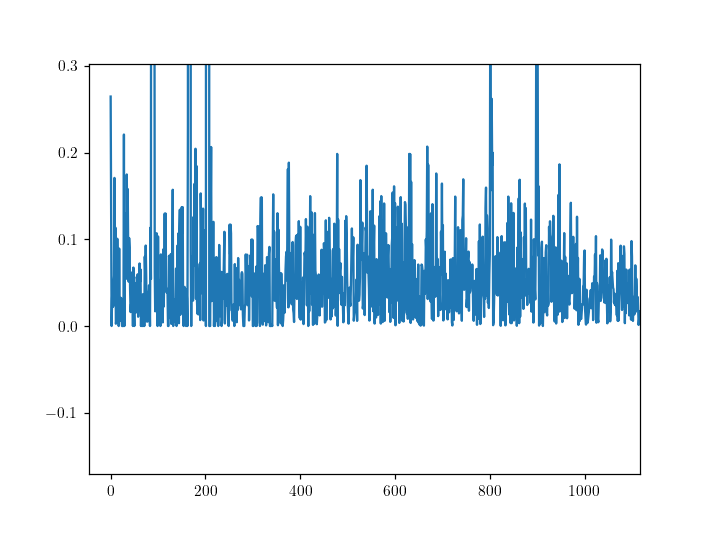

In [48]:
plt.figure()
plt.plot(np.abs(dy_dx))

In [51]:
m, med, std = sigma_clipped_stats(np.abs(dy_dx))

In [49]:
np.nanstd(np.abs(dy_dx))

1.0246072701384137

In [82]:
def _smooth_spec(spec,sigma=5):
    y = spec.flux
    y /= np.nanmedian(y)
    x = spec.wave
    dy_dx = (np.gradient(y, x))
    m, med, std = sigma_clipped_stats(np.abs(dy_dx))

    # Define a threshold for the gradient (you may need to tune this)
    gradient_threshold = med + sigma*std

    # Identify where the gradient exceeds the threshold
    sharp_feature_mask = np.abs(dy_dx) > gradient_threshold

    x_valid = x[~sharp_feature_mask]  # x values where sharp features are not present
    y_valid = y[~sharp_feature_mask]  # corresponding y values
    # Clip or smooth the spectrum at sharp features (using Gaussian smoothing as an example)
    interp_func = interp1d(x_valid, y_valid, kind='linear', fill_value="extrapolate")

    # Apply the interpolation to fill the masked sharp feature regions
    y_filled = y.copy()
    y_filled[sharp_feature_mask] = interp_func(x[sharp_feature_mask])
    y_filled = y_filled * np.nanmedian(y)
    s = S.ArraySpectrum(x,y,fluxunits='flam',name=str(spec.name)+'_smooth')
    return s

In [83]:
blue_spec.name

4039600536433072512

In [85]:
s = _smooth_spec(blue_spec)

In [76]:
smooth = savgol_filter(y_filled,101,1)


m = ~sigma_clip(blue_spec.flux,sigma=5).mask

<IPython.core.display.Javascript object>


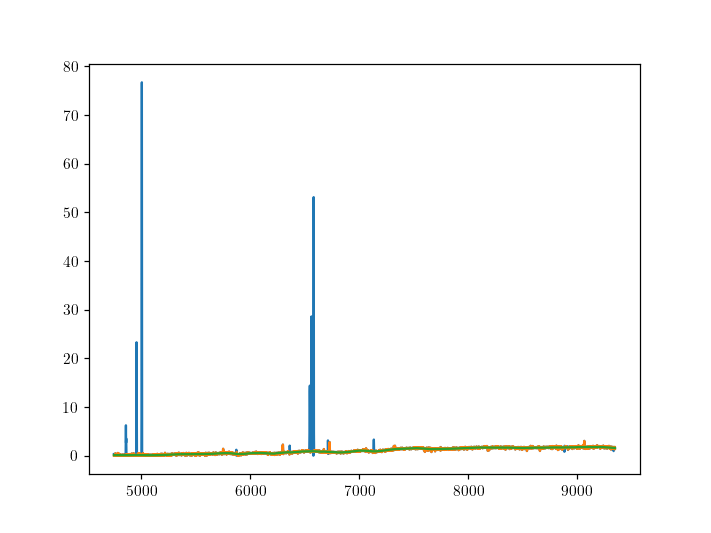

In [77]:
plt.figure()
#plt.plot(blue_spec.wave,blue_spec.flux)
plt.plot(x,y)
plt.plot(x,y_filled)

In [20]:
from astropy.coordinates import SkyCoord
import astropy.units as units
from dustmaps.bayestar import BayestarQuery
from astropy.io import fits
from astropy.wcs import WCS
hdu = fits.open('../../../kill_me/p119Dust.fits')
dust = hdu[0].data
wcs = WCS(hdu[0])

xx, yy = wcs.all_world2pix(test.cat.ra.values,test.cat.dec.values,0)

In [21]:
bayestar = BayestarQuery()
coords = SkyCoord(test.cat.ra.values*units.deg, test.cat.dec.values*units.deg,
                  distance=100.*units.pc, frame='galactic')

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 27.819 s
  pix_info:   0.443 s
   samples:  14.677 s
      best:   2.909 s
       nan:   0.035 s
      sort:   9.673 s
       idx:   0.081 s


In [14]:
import matplotlib.ticker as ticker
import numpy as np

<IPython.core.display.Javascript object>


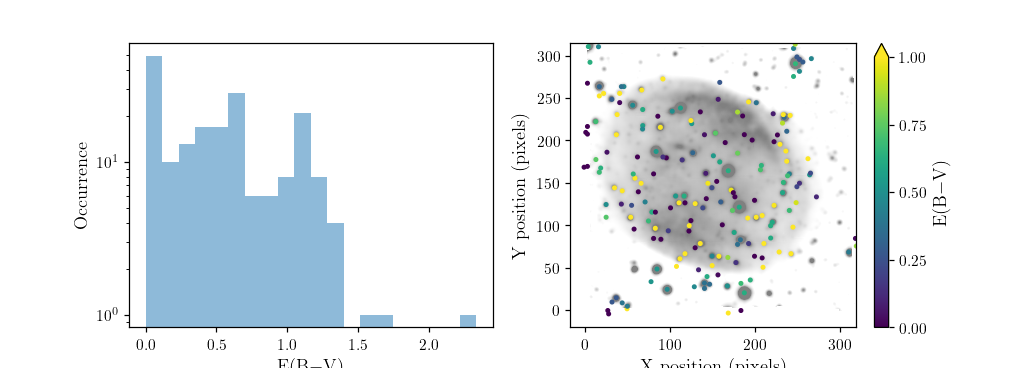

In [15]:
plt.figure(figsize=(1.4*fig_width*2,1*fig_width))
plt.subplot(122)
plt.imshow(test.image,cmap='gray_r',vmin=vmin,vmax=vmax+200,origin='lower',alpha=0.5)
plt.scatter(test.cat.x.values,test.cat.y.values,c=test.ebvs,vmax=1,s=5,facecolors='none',cmap='viridis')
col = plt.colorbar(extend='max')
col.ax.set_ylabel(r'E$($B$-$V$)$',fontsize=12)

def format_func(x, pos):
    return '{:.2f}'.format(x)
#col.ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_func))
col.locator = ticker.MaxNLocator(nbins=4)
col.update_ticks()

plt.xlabel('X position (pixels)',fontsize=12)
plt.ylabel('Y position (pixels)',fontsize=12)

plt.subplot(121)
plt.hist(test.ebvs,alpha=0.5,bins=20)
plt.xlabel(r'E$($B$-$V$)$',fontsize=12)
plt.ylabel('Occurrence',fontsize=12)
plt.yscale('log')

#plt.savefig('Extinction_nebula_ck+.pdf',bbox_inches='tight')

In [16]:
test.cat.iloc[np.isfinite(test.cat.Dist.values)]

_q          ra        dec                   id  e_RA_ICRS  e_DE_ICRS  \
46    1  273.009042 -33.877753  4039600497768848256     0.0208     0.0175   
50    1  273.007719 -33.876342  4039600497769635328     0.0260     0.0221   
729   1  273.003678 -33.861340  4039600605263902080     0.0308     0.0268   
403   1  273.008993 -33.868357  4039600566489162368     0.0352     0.0305   
554   1  273.008116 -33.870743  4039600570904748800     0.0427     0.0369   
51    1  273.013797 -33.876121  4039600497769638912     0.0485     0.0406   
213   1  273.014686 -33.867082  4039600532132309376     0.0459     0.0404   
214   1  273.019137 -33.862820  4039600532132471424     0.0521     0.0460   
400   1  272.999450 -33.873681  4039600566489122048     0.0620     0.0538   
49    1  273.017822 -33.876665  4039600497769631488     0.0726     0.0617   
112   1  273.010862 -33.875678  4039600502073223168     0.0930     0.0802   
382   1  273.010754 -33.868503  4039600536544395392     0.1138     0.1010   
120   1  273.009087 -33.875892  4039600502073248768     0.0971     0.0860   
337   1  273.011776 -33.867210  4039600536433080704     0.1294     0.1160   

        Plx   e_Plx     PM   pmRA  ...        G_filt           x           y  \
46   0.3220  0.0238  1.151  0.038  ...  GAIA/GAIA3.G  168.499236   -3.500027   
50   0.1205  0.0300  9.281 -1.373  ...  GAIA/GAIA3.G  187.500001   20.356382   
729  0.0963  0.0350  6.568 -2.952  ...  GAIA/GAIA3.G  247.773197  290.500000   
403  0.0803  0.0388  9.129  2.677  ...  GAIA/GAIA3.G  168.500024  164.324391   
554  0.0913  0.0449  1.703 -0.441  ...  GAIA/GAIA3.G  181.500200  121.368895   
51   0.0918  0.0541  5.474 -3.862  ...  GAIA/GAIA3.G   96.500003   24.484279   
213  0.1202  0.0530  5.145 -3.763  ...  GAIA/GAIA3.G   83.450780  187.014854   
214  0.5755  0.0545  2.224 -0.362  ...  GAIA/GAIA3.G   16.500043  263.499999   
400  0.1187  0.0712  8.469  0.776  ...  GAIA/GAIA3.G  310.616805   68.402470   
49   0.2428  0.0754  0.749  0.719  ...  GAIA/GAIA3.G   36.500001   14.499958   
112  0.4400  0.1078  5.141 -1.276  ...  GAIA/GAIA3.G  140.500001   31.820452   
382  1.0713  0.1288  3.291  1.109  ...  GAIA/GAIA3.G  142.051711  161.244884   
120  0.1018  0.1127  7.801 -0.989  ...  GAIA/GAIA3.G  167.499791   28.499911   
337  0.0822  0.1460  4.440 -2.935  ...  GAIA/GAIA3.G  126.674213  185.499943   

     xint  yint  fuzz  cal_source  containment  x_offset  y_offset  
46    168    -4     0           0     0.000000  0.499236  0.499973  
50    188    20     0           1     1.000000 -0.499999  0.356382  
729   248   290     0           1     1.000000 -0.226803  0.500000  
403   169   164     1           0     1.000000 -0.499976  0.324391  
554   182   121     1           0     1.000000 -0.499800  0.368895  
51     97    24     0           1     1.000000 -0.499997  0.484279  
213    83   187     1           0     1.000000  0.450780  0.014854  
214    17   263     0           1     0.999970 -0.499957  0.499999  
400   311    68     0           0     0.818964 -0.383195  0.402470  
49     37    14     0           1     0.999949 -0.499999  0.499958  
112   141    32     0           1     1.000000 -0.499999 -0.179548  
382   142   161     1           0     1.000000  0.051711  0.244884  
120   167    28     0           1     1.000000  0.499791  0.499911  
337   127   185     1           0     1.000000 -0.325787  0.499943  

[14 rows x 68 columns]

In [22]:
ind = test.cat.Dist.values- 1867 > 0
ind2 = test.cat.Dist.values- 1867 < 0
ind3 = (test.ebvs > 0.5)

In [28]:
test.cat.iloc[ind3].Dist

46     5131.5660
50     3089.6848
212          NaN
729    4075.2825
403    2352.2222
         ...    
569          NaN
619          NaN
205          NaN
533          NaN
178          NaN
Name: Dist, Length: 93, dtype: float64

In [26]:
test.ebvs[ind]

array([1.21, 0.62, 0.66, 0.62, 0.6 , 0.47, 0.54, 0.41, 0.08])

<IPython.core.display.Javascript object>


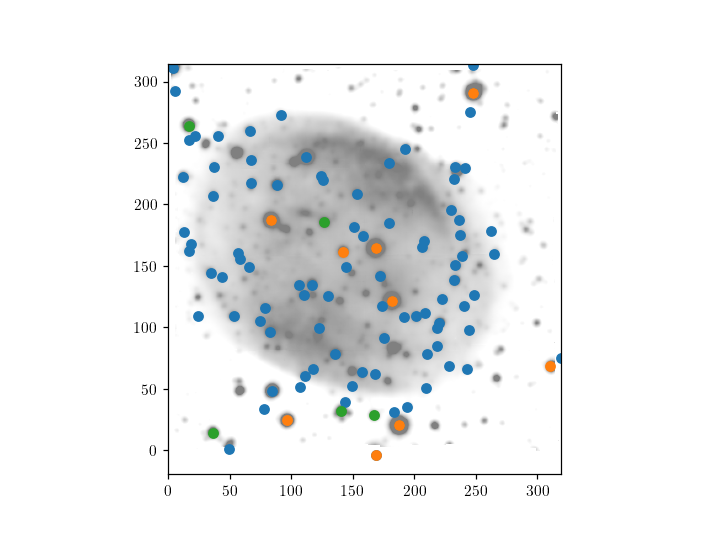

In [24]:
plt.figure()
plt.imshow(test.image,cmap='gray_r',vmin=vmin,vmax=vmax+200,origin='lower',alpha=0.5)
plt.scatter(test.cat.x.iloc[ind3],test.cat.y.iloc[ind3])
plt.scatter(test.cat.x.iloc[ind],test.cat.y.iloc[ind])
plt.scatter(test.cat.x.iloc[ind2],test.cat.y.iloc[ind2])


<IPython.core.display.Javascript object>


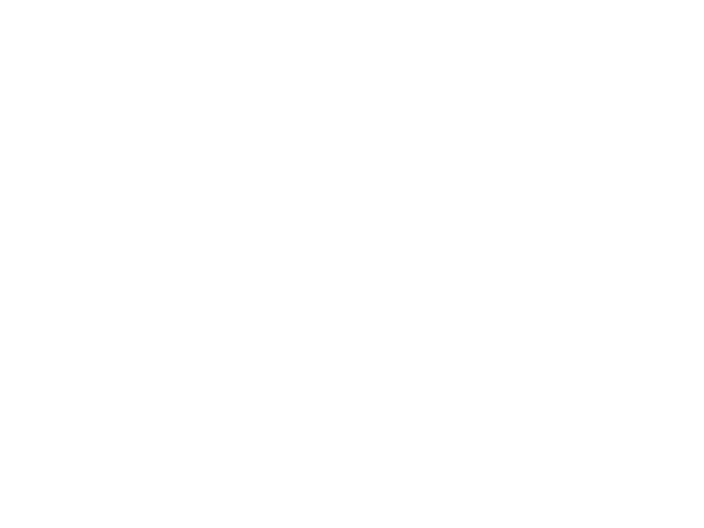

AttributeError: 'starkiller' object has no attribute 'ebvs'

In [4]:
plt.figure()
plt.hist(test.ebvs)

array([[0.29614633, 0.29616104, 0.29625326, ..., 0.49002418, 0.48569497,
        0.50551605],
       [0.29626849, 0.29806896, 0.30058009, ..., 0.48175475, 0.48187099,
        0.49701317],
       [0.29452307, 0.30186897, 0.30372649, ..., 0.47585625, 0.47950405,
        0.47924141],
       ...,
       [0.18742341, 0.18233357, 0.18022901, ..., 0.33734688, 0.3337623 ,
        0.32897374],
       [0.18329402, 0.18078704, 0.17840707, ..., 0.33049873, 0.32577244,
        0.32352106],
       [0.17822726, 0.17834995, 0.17832511, ..., 0.32246694, 0.31827293,
        0.31367122]])

In [127]:
hdu[0].header

SIMPLE  =                    T                                                  
BITPIX  =                  -64                                                  
NAXIS   =                    2                                                  
NAXIS1  =                   82                                                  
NAXIS2  =                   82                                                  
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BUNIT   = 'mag E(B-V)'                                                          
CTYPE1  = 'RA---TAN'                                                            
CTYPE2  = 'DEC--TAN'                                                            
CRVAL1  =           276.000000                                                  
CRVAL2  =           -30.0000